# EMRI Waveforms

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from lisatools.diagnostic import *
from lisatools.sensitivity import get_sensitivity

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import *
from few.utils.utility import *
from few.trajectory.inspiral import EMRIInspiral
traj_module = EMRIInspiral(func="KerrEccEqFlux")
from few.trajectory.ode.flux import KerrEccEqFlux

from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from few.utils.fdutils import *

import warnings
warnings.filterwarnings("ignore")

##### Initialize the generators

In [2]:
metric = "FastKerrEccentricEquatorialFlux"   # Kerr
#metric = "FastSchwarzschildEccentricFlux"    # Schw

few_gen = GenerateEMRIWaveform(
    metric,
    sum_kwargs=dict(pad_output=True, output_type="fd", odd_len=True),
    return_list=False,
)

td_gen = GenerateEMRIWaveform(
    metric,
    sum_kwargs=dict(pad_output=True, odd_len=True),
    return_list=False,
)

Set the values of the parameters

In [3]:
# Define injection parameters
M = 1e6  # central object mass
a = 0.9  # spin (will be ignored in Schwarzschild waveform)
mu = 1e2  # secondary object mass
p0 = 12.0  # initial semi-latus rectum
e0 = 0.4  # eccentricity
x0 = 1.0  # cosine of inclination (will be ignored in Schwarzschild waveform)

qK = np.pi / 3  # polar spin angle (theta)    --> tilt w/ respect to horizontal
phiK = np.pi / 3  # azimuthal viewing angle
qS = np.pi / 3  # polar sky angle             --> location in the sky
phiS = np.pi / 3  # azimuthal viewing angle
dist = 1.0  # distance

# initial phases
Phi_phi0 = np.pi / 3
Phi_theta0 = 0.0
Phi_r0 = np.pi / 3



Tobs = 0.5  # observation time, if the inspiral is shorter, the it will be zero padded
dt = 10.0  # cadence
eps = 1e-4  # mode content percentage

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
    "eps": eps,
}


# get the initial p0 
p0 = get_p_at_t(
    traj_module,
    Tobs*0.99,
    [M, mu, 0.0, e0, 1.0],
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    traj_kwargs={},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)


emri_injection_params = [
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
]

### Noise in frequency domain

Define the function that generates the noise in frequency domain (different gaussian realisation with sigma 
for the real and imaginary part fo the FD signal)

In [4]:
def generate_frequency_domain_noise_lisa(psd_pos, dt, N_obs):
    
    sigma = 0.5 * (psd_pos / (1.0 / (N_obs * dt))) ** 0.5

    noise = np.random.normal(0.0, sigma) + 1j * np.random.normal(0.0, sigma)

    return noise

Generate FD signal

In [5]:
# generate TD signal
data_channels_td = td_gen(*emri_injection_params, **waveform_kwargs)
N_obs = len(data_channels_td)

# generate the frequecies (ascending order)  
freq = np.fft.fftshift(np.fft.fftfreq(len(data_channels_td), dt))

# find the positive (non-negative) frequencies
positive_frequency_mask = (freq>=0)

# use the frequencies found to generate the FD signal (only for positive frequency)
fd_kwargs = waveform_kwargs.copy()
fd_kwargs['f_arr'] = freq   # otherwise specify here
fd_kwargs['mask_positive']=True

# generate FD waveform
hf = few_gen(*emri_injection_params,**fd_kwargs)

Generate FD noise and add it to the FD signal

In [6]:
# generate psd, ONLY for non-negative frequencies
pos_psd = get_sensitivity(freq[positive_frequency_mask], return_type="PSD")

# add noise to signal
hf_noise = hf + generate_frequency_domain_noise_lisa(pos_psd, dt, N_obs)

print('FD noise: ', hf_noise)

FD noise:  [            nan           -infj -1.62098988e-04-1.48130639e-04j
  1.48859592e-04+3.97106167e-05j ... -4.92258386e-17-4.25206807e-17j
 -9.70227121e-17+1.56296042e-16j  2.64759179e-19+8.13006531e-18j]


Note: PSD at freq=0 is inf. Here shouldn't be a problem but I have to address it for TD (I think).

Plot in characteristic strain representation

$$ h_c^2 = 4 f^2 |\tilde{h}(f)|^2 $$
$$ h_n^2= f S_n(f) $$

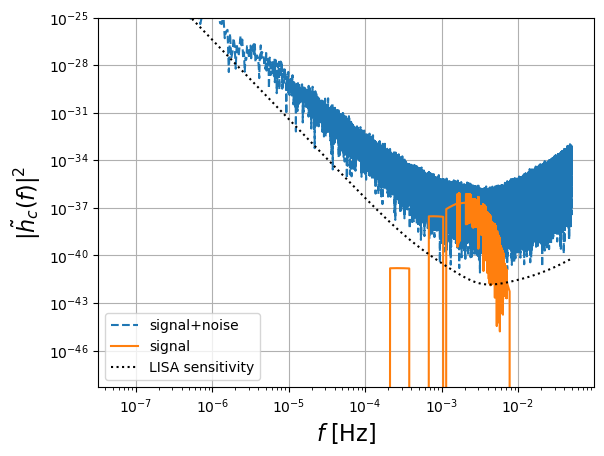

In [7]:
plt.loglog(freq[positive_frequency_mask], 4 * freq[positive_frequency_mask] **2 * np.abs(hf_noise) **2 ,'--',label='signal+noise')
plt.loglog(freq[positive_frequency_mask], 4 * freq[positive_frequency_mask] **2 * np.abs(hf) **2,label='signal')
plt.loglog(freq[positive_frequency_mask], pos_psd*freq[positive_frequency_mask],'k:',label='LISA sensitivity')
plt.ylabel(r'$| \tilde{h}_c (f)|^2$',fontsize=16)
plt.grid()
plt.xlabel(r'$f$ [Hz]',fontsize=16)
plt.legend(loc='lower left')
plt.ylim([0.5e-48, 1e-25])
plt.show()

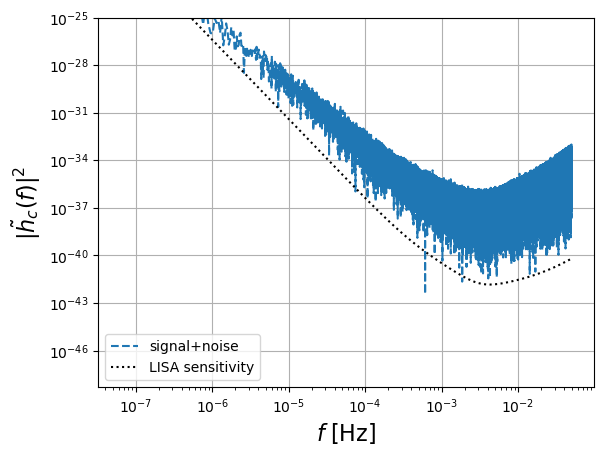

In [8]:
plt.loglog(freq[positive_frequency_mask], 4 * freq[positive_frequency_mask] **2 * np.abs(generate_frequency_domain_noise_lisa(pos_psd, dt, N_obs)) **2 ,'--',label='signal+noise')
#plt.loglog(freq[positive_frequency_mask], 4 * freq[positive_frequency_mask] **2 * np.abs(hf) **2,label='signal')
plt.loglog(freq[positive_frequency_mask], pos_psd*freq[positive_frequency_mask],'k:',label='LISA sensitivity')
plt.ylabel(r'$| \tilde{h}_c (f)|^2$',fontsize=16)
plt.grid()
plt.xlabel(r'$f$ [Hz]',fontsize=16)
plt.legend(loc='lower left')
plt.ylim([0.5e-48, 1e-25])
plt.show()

### Noise in Time Domain

Define the function that generates the noise in TD:
- two gaussian realizations, one for real and one for imaginary part of FD noise
- real inverse FFT for this complex FD noise $\to$ TD noise
- repeat this two times, one for the real (+) and one for the imaginary ($\times$) part of TD signal

##### NB: I'm using the PSD only for frequencies bigger than 5e-4

In [9]:
def generate_time_domain_noise_lisa(pos_psd, dt, N_obs):
    
    sigma = 0.5 * (pos_psd / (1.0 / (N_obs * dt))) ** 0.5
    
    noise_real = np.random.normal(0.0, sigma) + 1j * np.random.normal(0.0, sigma)
    
    noise_time_domain = np.fft.irfft(noise_real, n=N_obs) / dt
    print('noise_time_domain: ', noise_time_domain)
    
    return noise_time_domain

In [10]:
# generate TD signal
data_channels_td = td_gen(*emri_injection_params, **waveform_kwargs)
time_array = np.arange(0,len(data_channels_td))*dt
N_obs = len(data_channels_td)

# generate the frequecies (ascending order) 
freq = np.fft.fftshift(np.fft.fftfreq(len(data_channels_td) , dt))
print('freq: ', freq)

# find the positive (non-negative) frequencies
positive_frequency_mask = (freq>5e-4)

freq:  [-0.04999997 -0.0499999  -0.04999984 ...  0.04999984  0.0499999
  0.04999997]


Generate TD noise and add it to the TD signal

In [11]:
# generate psd, ONLY for non-negative frequencies
pos_psd = get_sensitivity(freq[positive_frequency_mask], return_type="PSD")

# generate two realizations for the noise, one for real and one for imaginary part
noise_td_re = generate_time_domain_noise_lisa(pos_psd, dt, N_obs)
noise_td_im = generate_time_domain_noise_lisa(pos_psd, dt, N_obs)

# add TD noise to TD signal
data_channels_td_noise = data_channels_td + (noise_td_re + 1j * noise_td_im)

print(data_channels_td_noise)

noise_time_domain:  [-8.61552548e-21  4.92756566e-21 -3.83334113e-22 ... -3.52854692e-21
 -5.10781827e-21  4.41956304e-21]
noise_time_domain:  [ 2.35652571e-22 -6.83271131e-21 -1.13545955e-20 ... -4.29795051e-21
 -1.09834991e-20 -1.39003426e-20]
[-7.65314885e-21+9.75546048e-22j  5.81584231e-21-6.03939701e-21j
  4.30065661e-22-1.05155371e-20j ... -1.94438149e-21-5.88777816e-21j
 -3.31131412e-21-1.22790340e-20j  4.41956304e-21-1.39003426e-20j]


Plot only the noise

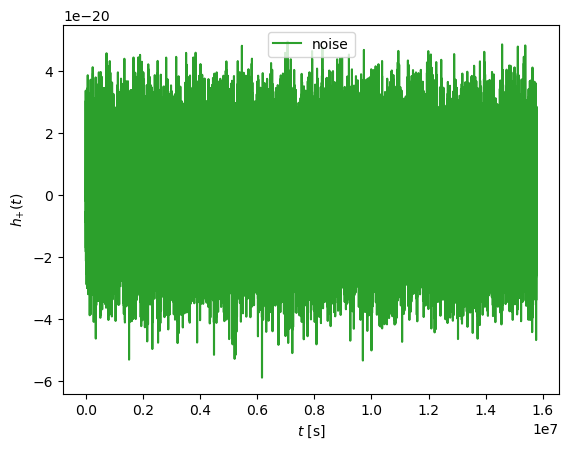

In [12]:
plt.plot(time_array, noise_td_re, label='noise', c='C2')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')

t0 = time_array[-1]*0.7
space_t = 1.3*10e3
#plt.xlim([t0,(t0+space_t)])
#plt.ylim([4.22e-17, 4.26e-17])
#plt.ylim([-1.275e-17, -1.25e-9])
plt.legend(loc='upper center')
plt.show()

Plot of + polarization signal (real part of signal) 

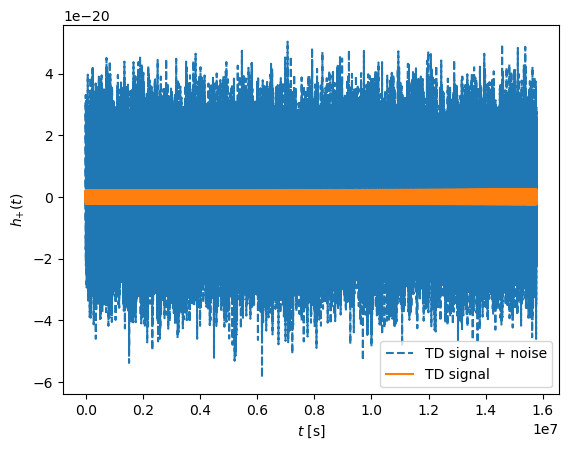

In [13]:
plt.plot(time_array, data_channels_td_noise.real,'--' ,label='TD signal + noise')
plt.plot(time_array, data_channels_td.real,label='TD signal')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')

t0 = time_array[-1]*0.7
space_t = 1.3*10e3
#plt.xlim([t0,(t0+space_t)])
#plt.ylim([4.22e-17, 4.26e-17])
#plt.ylim([-1.275e-17, -1.25e-9])
plt.legend()
plt.show()

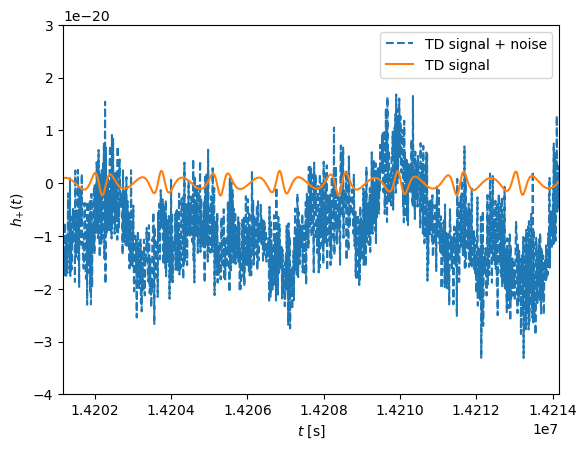

In [14]:
plt.plot(time_array, data_channels_td_noise.real,'--' ,label='TD signal + noise')
plt.plot(time_array, data_channels_td.real,label='TD signal')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')

t0 = time_array[-1]*0.9
space_t = 1.3*10e3
plt.xlim([t0,(t0+space_t)])
plt.ylim([-4e-20, 3e-20])
#plt.ylim([-1.275e-17, -1.25e-9])
plt.legend()
plt.show()

## Check for noise in frequency domain

Generate FD noise and signal, then sum them.

In [15]:
# generate TD signal
data_channels_td = td_gen(*emri_injection_params, **waveform_kwargs)
N_obs = len(data_channels_td)

# generate the frequecies (ascending order)  
freq = np.fft.fftshift(np.fft.fftfreq(len(data_channels_td), dt))

# find the positive (non-negative) frequencies
positive_frequency_mask = (freq>=0)

# use the frequencies found to generate the FD signal (only for positive frequency)
fd_kwargs = waveform_kwargs.copy()
fd_kwargs['f_arr'] = freq   # otherwise specify here
fd_kwargs['mask_positive']=True

# generate FD waveform
hf = few_gen(*emri_injection_params,**fd_kwargs)

# generate psd, ONLY for non-negative frequencies
pos_psd = get_sensitivity(freq[positive_frequency_mask], return_type="PSD")

# add noise to signal
hf_noise = hf + generate_frequency_domain_noise_lisa(pos_psd, dt, N_obs)

print('FD noise: ', hf_noise)

FD noise:  [            nan           +infj  4.96859978e-04-4.51135263e-04j
  3.84574376e-05+4.89306648e-05j ...  3.69937366e-18+2.53734391e-17j
  1.06025417e-18-1.81546377e-17j -1.44281914e-16+1.28515756e-16j]


Compute the fft of the signal+noise in TD, to obtain the corresponding signal in FD.

In [16]:
# take the FFT of the plus polarization and shift it (ordered values) 
fft_TD = np.fft.fftshift(np.fft.fft(data_channels_td_noise)) * dt  # dt for normalization
fft_freq = np.fft.fftshift(np.fft.fftfreq(len(data_channels_td_noise) , dt))

# define the positive frequencies
fft_positive_frequency_mask = (fft_freq>=0.0)

Plot the two FD signal+noise

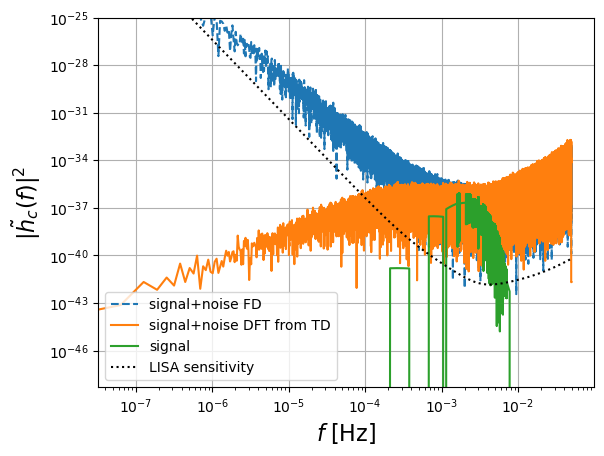

In [17]:
plt.loglog(freq[positive_frequency_mask], 4 * freq[positive_frequency_mask] **2 * np.abs(hf_noise) **2 ,'--',label='signal+noise FD')
plt.loglog(fft_freq[fft_positive_frequency_mask], 4 * fft_freq[fft_positive_frequency_mask] **2 * np.abs(fft_TD[fft_positive_frequency_mask]) **2,
           label='signal+noise DFT from TD')
plt.loglog(freq[positive_frequency_mask], 4 * freq[positive_frequency_mask] **2 * np.abs(hf) **2,label='signal')
plt.loglog(freq[positive_frequency_mask], pos_psd*freq[positive_frequency_mask],'k:',label='LISA sensitivity')
plt.ylabel(r'$| \tilde{h}_c (f)|^2$',fontsize=16)
plt.grid()
plt.xlabel(r'$f$ [Hz]',fontsize=16)
plt.legend(loc='lower left')
plt.ylim([0.5e-48, 1e-25])
plt.show()

Both the noises seem off in this plot.

The ascending part of DFT signal+noise makes sense (I think) because we used the PSD and noise only for
frequencies >5e-4 (and from this frequency on, the two signals seem to overlap).